# Vertices

In [104]:
import numpy as np
from math import comb
from scipy.linalg import solve, LinAlgError
import matplotlib.pyplot as plt

### Below is written a Python function called `vertices` which finds all vertices of the convex polytope of feasible solutions.

### By Mauricio Soroco - 60785250
### Mathematics 441
### Portfolio object 4

Given a linear programming problem, one way to find the optimal solution is by checking every possible vertex and calculating the value of the objective function at that point. From linear programming theory, we know that if an optimal solution exists (and is not unbounded), then that optimal solution will occur at least at one vertex of the polytope defining the feasible set. Thus the natural brute force method that arises would be to check every vertex and compare the values of the objective function.

At the end of the notebook, there is an example of the `vertices` function which finds all the vertices of the feasible set. Then for each vertex returned by `vertices` we check its objective function value and search for the optimal solution.

# Code

In [105]:
### compute the vertex at the intersection of
### all the hyperplanes given in C in a 
### d-dimensional space.
def compute_intersect(C, d):
    A = C[:,0:d]
    b = C[:,-1]
    return solve(A, b)

My function will compute the vertex for every possible combination of hyperplanes. One issue with this brute force method is that certain vertices will be recomputed multiple times due to the different ways to permute the same constraints. I attempted to employ a primitive version of `memoization` (ie checking to see if the result was computed before attempting to compute it) but didn't find a datastructure small enough to hold the values (I ran out of memory).
For this reason among others, this method does not have a performant runtime.

`vertices` works by listing every possible permutation of hyperplanes (see `find_intersect`) and computing their vertex. Then for each vertex, we check if its feasible. If it is, we keep it since it is a boundary for the polytope defining the feasible set.

`RSF` was intended to be a datastructure that holds the resulting vertex at the intersection of the given hyperplanes. Thus, later in the execution of the code, when the same set of hyperplanes (just permuted in some new order) are used to compute the vertex, we could save time by checking `RSF` instead of recomputing the result. I left this in to code (commented out) to understand in theory how it would work, and for possible modifications in the future.

In [106]:
### produces every possible vertex location by considering 
### all possible intersections of hyperplanes
###
### Params:
## C:       Matrix encoding the constraints A and b as [A|b]
##
## indices: indices of the hyperplanes in C to consider
##          when solving for a vertex. Every hyperplanes 
##          results from a permutation of these indices.
##
## d:       the dimension of the problem space
##
## RSF:     A result accumulator for memoization. This stores
##          the results of previously computed vertices to 
##          avoid duplicate work. (result-so-far)
##          TODO: find a better datastructure to save space
##
## V:       Stores the return values (vertices)
##          TODO: combine RSF and V
##
## ptr:     Dictates the current recursive level and which
##          index in indices we are iterating.
##
def find_intersect(C, indices, d, RSF, V, ptr, verbose):
    if ((len(indices) == d) and (ptr == d)):
        # v = np.empty(d)
        # index = int(''.join([str(i) for i in indices]))
        # if any(RSF[index] == np.inf):
        #     v = compute_intersect(C[indices], d)
        #     RSF[index] = v
        # return RSF[index]
        return compute_intersect(C[indices], d)
        
    
    else:
        for i in range(np.shape(C)[0]):    
            if i not in indices:
                indices[ptr] = i
                try:
                    intersect = find_intersect(C, indices, d, RSF, V, ptr + 1, verbose)
                    if (len(V) < 2):
                        if (V[0] == np.inf):
                            V = intersect
                    else:
                        V = np.vstack([V, intersect])
                except(LinAlgError):
                    if (verbose):
                        print("Skipping solving for vertices with singular matrices\n")
        return V

In [107]:
### Finds the non-constraint-violating vertices of a
### polytope given a LP problem of the form Ax <= b

### Assumes that the system is not underdetermined.
##
def vertices(A, b, verbose=False):
    (n, d) = np.shape(A)
    for i in range(d):
        a = np.full(d, 0)
        a[i] = -1
        A = np.vstack([A, a])
        b = np.hstack([b, 0])
    (n, d) = np.shape(A)

    ############# for memoization
    RSF = -1 
    # RSF = np.full([int(''.join([str(i) for i in range(n-1, -1, -1)])), d], -1)
    #############

    indices = np.full(d, -1)
    # find intersection (vertex)
    V = find_intersect(np.hstack([A, np.array([b]).T ]), indices, d, RSF, [np.inf], 0, verbose)

    ## filter out constraint violating vertices
    V_good = []
    for i in range(len(V)):
        # if vertex satisfies constraints, keep it
        v = V[i].T
        if (np.dot(A, v) <= b).all():
            if len(V_good) == 0:
                V_good = V[i]
            else:
                V_good = np.vstack([V_good, V[i]])
        
    return np.unique(V_good, axis=0).T

# Example

The following example is taken from [Elementary Liner Programming](https://go.exlibris.link/2XPGwSh4) by Beck and Kolman (seee Appendix A).

In [108]:
A = np.array([[-3,1],[-1,1],[-1,2],[0,1],[1,2],[.9,.9],[1,0],[1,-1],[1,-2],[1,-3]])
b = np.array([1,3,8,6,18,12,9,6,4,3])
c = np.array([20,30])

In [109]:
V = vertices(A,b, True)
print(V.round(2))

Skipping solving for vertices with singular matrices

Skipping solving for vertices with singular matrices

Skipping solving for vertices with singular matrices

Skipping solving for vertices with singular matrices

Skipping solving for vertices with singular matrices

Skipping solving for vertices with singular matrices

Skipping solving for vertices with singular matrices

[[-0.   -0.    1.    2.    3.    4.    6.    6.    8.    8.67  9.    9.  ]
 [-0.    1.    4.    5.   -0.    6.    1.    6.    2.    4.67  3.    4.33]]


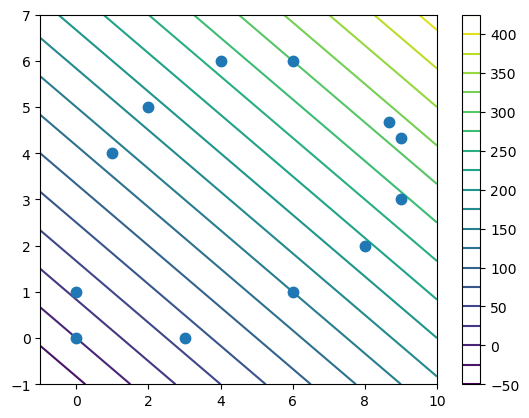

In [110]:
plt.plot(V[0,:],V[1,:],'.',ms=15)
X,Y = np.meshgrid(np.linspace(-1,10),np.linspace(-1,7))
Z = c[0]*X + c[1]*Y
plt.contour(X,Y,Z,levels=20), plt.colorbar()
plt.show()

In [111]:
def solveLP(c,A,b):
    V = vertices(A,b)
    cs = c@V
    index = np.argmax(cs)
    return V[:,index],cs[index]

In [112]:
solveLP(c,A,b)

(array([8.66666667, 4.66666667]), 313.3333333333333)

In [113]:
%%timeit

solveLP(c,A,b)

232 ms ± 4.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Pseudo-code

In [114]:
# psuedo-code

# def vertices(A, b):
#     (n, d) = np.shape(A)
#     # for every constraint group               
#         # find intersection (vertex)

#         ## filter out nonsensical vertices
#             # for every constraint
#                 # if vertex satisfies constraints, keep it